# Zivich et al. (2025): An Introduction to Confidence Bands

Zivich et al. (2025) provides an introduction to different types of confidence regions, including confidence bands. Briefly, confidence bands are an extension of confidence intervals for vectors (or multiple) parameters. The issue with standard confidence intervals, is that they only claim a single parameter at that rate. When considering coverage for *multiple* parameters, simultaneous confidence interval coverage can be far below the nominal rate. Confidence bands are a set of intervals for a set of parameters. 

In Zivich et al., the primary focus is on the sup-t method for computing the confidence bands. The sup-t method adjusts the overall critical value such that it provides a set of confidence regions corresponding to the $1-\alpha$ coverage rate. See the publication for further details on the procedure. 

Here, we will replicate the analysis shown in the Supplementary Materials of Zivich et al. This example covers the usage of confidence bands with nuisance parameter estimation. Data comes from the AIDS Clinical Trial Group (ACTG) 175, which compared 2-drug versus 1-drug antiretroviral therapy for the prevention of disease progression among people with HIV.

## Setup

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from formulaic import model_matrix

import delicatessen
from delicatessen import MEstimator
from delicatessen.estimating_equations import ee_regression
from delicatessen.sandwich import compute_confidence_bands
from delicatessen.utilities import inverse_logit, spline, regression_predictions

print("Versions")
print("NumPy:       ", np.__version__)
print("SciPy:       ", sp.__version__)
print("pandas:      ", pd.__version__)
print("Matplotlib:  ", mpl.__version__)
print("Delicatessen:", delicatessen.__version__)

Versions
NumPy:        1.25.2
SciPy:        1.11.2
pandas:       1.4.1
Matplotlib:   3.9.2
Delicatessen: 3.2


In [2]:
d = pd.read_csv("data/actg175.csv")

Hereafter, we will estimate each parameter using an inverse probability weighting (IPW) estimator. See the Hernan and Robins applied examples for further details. Briefly, we will estimate the probability of antiretroviral therapy type given baseline covariates. This probability is commonly referred to as the propensity score. Using the estimated propensity score, we will then construct the inverse probability of treatment weights. These weights will then be used to estimate the causal parameters of interest by either using a weighted mean or a marginal structural model.

## Case Study 1: Multiple Outcomes

For the first case, we are interested in the average causal effect of 2-drug versus 1-drug antiretroviral therapy on CD4 and CD8 T cell counts 20-weeks post-randomization. CD4 and CD8 are immunological markers often used to assess immune function, and CD4 is a particular important immunological marker for assessing disease progression among people with HIV.

Here, we are interested in a *pair* of parameters, which we might indicate as a vector with two elements. For statistical inference, we want coverage for both parameters simultaneously. As such, reporting the confidence bands is appropriate here.

In [3]:
g_model = ("white + male + idu + C(karnof) "
           "+ age + age_rs1 + age_rs2 + age_rs3"
           "+ cd4c_0wk + cd4_rs1 + cd4_rs2 + cd4_rs3"
           "+ cd8c_0wk + cd8_rs1 + cd8_rs2 + cd8_rs3")
Wmat = model_matrix(g_model, data=d)
a = np.asarray(d['treat'])
y1 = np.asarray(d['cd4_20wk'])
y2 = np.asarray(d['cd8_20wk'])
n = a.shape[0]

In [4]:
def estfunc(theta):
    # Dividing up the parameters 
    psi_y, psi_z = theta[0], theta[1]
    mu_1, mu_0 = theta[2], theta[3]
    om_1, om_0 = theta[4], theta[5]
    alpha = theta[6:]

    # Constructing inverse probability weights
    pi_a = inverse_logit(np.dot(Wmat, alpha))
    ipw = a / pi_a + (1-a)/(1-pi_a)
    ef_ps = ee_regression(theta=alpha, X=Wmat, y=a, model='logistic')

    # Estimating functions for causal parameters
    ef_psi1 = np.ones(n)*(mu_1 - mu_0) - theta[0]
    ef_psi2 = np.ones(n)*(om_1 - om_0) - theta[1]
    ef_mu1 = a * ipw * (y1 - mu_1)
    ef_mu0 = (1-a) * ipw * (y1 - mu_0)
    ef_om1 = a * ipw * (y2 - om_1)
    ef_om0 = (1-a)* ipw * (y2 - om_0)

    # Returning stacked estimating functions
    return np.vstack([ef_psi1, ef_psi2, ef_mu1, ef_mu0, ef_om1, ef_om0, ef_ps])

In [5]:
# Estimating the parameters
inits = [0., 0., 300., 300., 300., 300., ] + [0., ]*Wmat.shape[1]
estr = MEstimator(estfunc, init=inits)
estr.estimate()
psi = estr.theta

# Confidence intervals
ci = estr.confidence_intervals()
# Confidence bands
cb = estr.confidence_bands(method='supt', subset=[0, 1], seed=10177)

In [6]:
print("95% Confidence Intervals")
print(ci[:2, :], '\n')
print("95% Confidence Bands")
print(cb)

95% Confidence Intervals
[[ 43.29000165  65.81961938]
 [-29.79387445  30.18212624]] 

95% Confidence Bands
[[ 41.81902345  67.29059758]
 [-33.70975933  34.09801112]]


As shown here, the confidence bands encapsulate the confidence intervals. These wider intervals are the price we pay to have simultaneous coverage of our parameters. However, this drop in precision is important since our interest (and thus our interpretations) are for more than one parameter). This distincton between confidence regions is slightly easier to understand visually. 

One item to note here is that the confidence bands were only computed for a *subset* of the parameter vector (i.e., the `subset=[0,1]` argument). This is due to the our inference only being on the parameters of interest. When computing the confidence bands here, we can ignore the nuisance parameters (since we are not making inference for them).

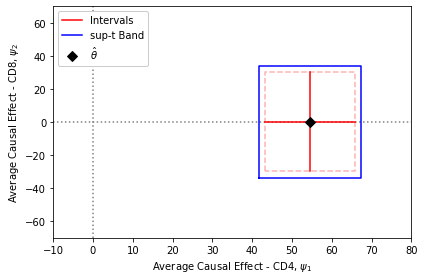

In [7]:
# References lines for the null
plt.axhline(linestyle=':', color='gray')
plt.axvline(linestyle=':', color='gray')

# Plotting Implied Confidence Interval Rectangle
plt.plot([ci[0, 0], ci[0, 0], ci[0, 1], ci[0, 1], ci[0, 0]],
         [ci[1, 0], ci[1, 1], ci[1, 1], ci[1, 0], ci[1, 0]],
         '--', color='red', alpha=0.3)
# Plotting Confidence Intervals
plt.plot([ci[0, 0], ci[0, 1]], [psi[1], psi[1]],
         '-', color='red', label='Intervals')
plt.plot([psi[0], psi[0]], [ci[1, 0], ci[1, 1]],
         '-', color='red')

# Plotting Confidence Bands
plt.plot([cb[0, 0], cb[0, 0], cb[0, 1], cb[0, 1], cb[0, 0]],
         [cb[1, 0], cb[1, 1], cb[1, 1], cb[1, 0], cb[1, 0]],
         color='blue', label='sup-t Band')

# Estimated Parameters
plt.plot([psi[0], ], [psi[1], ], 'D', color='k', markersize=7, label=r'$\hat{\theta}$')

# Plot Formatting
plt.ylim([-70, 70])
plt.ylabel(r"Average Causal Effect - CD8, $\psi_2$")
plt.xlim([-10, 80])
plt.xlabel(r"Average Causal Effect - CD4, $\psi_1$")
plt.legend(loc='upper left', framealpha=1.)
plt.tight_layout()
plt.show()

Using this visualization, we can imagine the true value of the parameters as a point in this 2 dimensional Euclidean space. Therefore, our confidence regions (rectangles here) claim to include that point 95% of the times as the number of computed regions from new samples goes to infinity. The red rectangle (implied by the confidence intervals) is too small to cover the parameter at that rate. The blue rectangle, or confidence bands, do coverage the true point at that rate. 

## Case Study 2: Effect Measure Modification by a Binary Covariate

For the second example, we are interested in studying modificiation of the effect of antiretroviral therapy on CD4 by gender. Here, we will estimate the following marginal structural model
$$ E[Y^a_i | V; \beta] = \beta_0 + \beta_1 a + \beta_2 V_i + \beta_3 a V_i $$
where $V_i$ is gender. Here, interest is in the full set of $\beta$ parameters (a vector of 4 numbers). Again, confidence bands are appropriate in this setting.

In [8]:
g_model = ("white + male + idu + C(karnof) "
           "+ age + age_rs1 + age_rs2 + age_rs3"
           "+ cd4c_0wk + cd4_rs1 + cd4_rs2 + cd4_rs3"
           "+ cd8c_0wk + cd8_rs1 + cd8_rs2 + cd8_rs3")
Wmat = model_matrix(g_model, data=d)
msm = model_matrix("treat + male + treat:male", data=d)
a = np.asarray(d['treat'])
y = np.asarray(d['cd4_20wk'])

In [9]:
def estfunc(theta):
    beta = theta[:4]
    alpha = theta[4:]

    # Estimating function for propensity score
    ef_ps = ee_regression(theta=alpha, X=Wmat, y=a, model='logistic')

    # Constructing weights
    pi_a = inverse_logit(np.dot(Wmat, alpha))
    ipw = a / pi_a + (1-a)/(1-pi_a)
    
    # Estimating function for MSM
    ef_msm = ee_regression(theta=beta, X=msm, y=y, model='linear', weights=ipw)

    # Returning stacked estimating functions
    return np.vstack([ef_msm, ef_ps])

In [10]:
# Estimating the parameters
inits = [300., 0., 0., 0.] + [0., ]*Wmat.shape[1]
estr = MEstimator(estfunc, init=inits)
estr.estimate()
psi = estr.theta

# Confidence intervals
ci = estr.confidence_intervals()
# Confidence bands
cb = estr.confidence_bands(method='supt', subset=[0, 1, 2, 3], seed=10177)

In [11]:
r = pd.DataFrame()
r['Names'] = list(msm.columns)
r['Estimate'] = np.round(psi[:4], 1)
r['Interval'] = [np.array2string(x) for x in np.round(ci[:4], 1)]
r['Bands'] = [np.array2string(x) for x in np.round(cb, 1)]
r.set_index('Names').T

Names,Intercept,male,treat,male:treat
Estimate,355.8,-27.1,43.4,13.5
Interval,[327.5 384.2],[-58.9 4.7],[ 8.1 78.7],[-26.5 53.6]
Bands,[323. 388.7],[-63.9 9.8],[ 2.4 84.3],[-32.9 59.9]


Again, the bands compensate for the fact that we are interested in simultaneous inference. Additionally, we restrict the computation of the confidence bands only to the parameters of interest (the first 4 parameters of `theta`).

## Case Study 3: Effect Measure Modification by a Continuous Covariate

For the final example, we are interested in studying modification by *baseline* CD4 cell counts. Again, we will use a marginal structural model. However, for a continuous variable we want to model it flexibly in our model. However, flexibly modeling a continuous variable makes it challenging to interpret. Thus, we plot the conditional average causal effect over values of baseline CD4 for interpretative purposes. 

The first part of the code will estimate the parameters of the specified marginal strucutral model

In [12]:
g_model = ("white + male + idu + C(karnof) "
           "+ age + age_rs1 + age_rs2 + age_rs3"
           "+ cd4c_0wk + cd4_rs1 + cd4_rs2 + cd4_rs3"
           "+ cd8c_0wk + cd8_rs1 + cd8_rs2 + cd8_rs3")
msm = model_matrix("treat + cd4c_0wk + cd4_rs1 + cd4_rs2 + cd4_rs3 "
                   "+ treat:(cd4c_0wk + cd4_rs1 + cd4_rs2 + cd4_rs3)", data=d)
a = np.asarray(d['treat'])
y = np.asarray(d['cd4_20wk'])

In [13]:
def estfunc(theta):
    beta = theta[:msm_size]
    alpha = theta[msm_size:]

    # Estimating function for propensity score
    ef_ps = ee_regression(theta=alpha, X=Wmat, y=a, model='logistic')

    # Constructing weights
    pi_a = inverse_logit(np.dot(Wmat, alpha))
    ipw = a / pi_a + (1-a)/(1-pi_a)
    
    # Estimating function for MSM
    ef_msm = ee_regression(theta=beta, X=msm, y=y, model='linear', weights=ipw)

    # Returning stacked estimating functions
    return np.vstack([ef_msm, ef_ps])

In [14]:
msm_size = msm.shape[1]
inits = [300, ] + [0, ]*(msm_size - 1) + [0., ]*Wmat.shape[1]
estr = MEstimator(estfunc, init=inits)
estr.estimate()

psi = estr.theta[:msm_size]
v_psi = estr.variance[:msm_size, :msm_size]

To create the plot, we will generate some data across a range of equally spaced values between the min and max observed CD4 values. Then I will recreate the splines for this grid (same as those used to fit the model). Using those values, we will compute the predicted 20-week CD4 from the model parameters using the `regression_predictions` function. From there, we will construct the covariance matrix of the predictions. Finally, we can use all those values to compute the confidence bands

In [15]:
# Creating grid of CD4 values for plotting
dp = pd.DataFrame()
dp['cd4c_0wk'] = np.linspace(np.min(d['cd4c_0wk']), np.max(d['cd4c_0wk']), 500)
dp['cd4_0wk'] = dp['cd4c_0wk'] * np.std(d['cd4_0wk']) + np.mean(d['cd4_0wk'])
dp[["cd4_rs1", "cd4_rs2", "cd4_rs3"]] = spline(dp['cd4c_0wk'], knots=np.percentile(d['cd4c_0wk'], [5, 35, 65, 95]),
                                               power=2)
dp['treat'] = 1
Xp = model_matrix("treat + cd4c_0wk + cd4_rs1 + cd4_rs2 + cd4_rs3 "
                  "+ treat:(cd4c_0wk + cd4_rs1 + cd4_rs2 + cd4_rs3)", data=dp)
xvals = np.asarray(dp['cd4_0wk'])

# Generating predictions from the estimated marginal structural model parameters 
y_hat = regression_predictions(X=Xp, theta=psi, covariance=v_psi)
y_vals = y_hat[:, 0]       # Predicted values from model
var = y_hat[:, 1]          # Variance for predictions
cov_p = Xp @ v_psi @ Xp.T  # Covariance matrix for predictions

In [16]:
cb = compute_confidence_bands(y_vals, covariance=cov_p, method='supt', seed=10177)

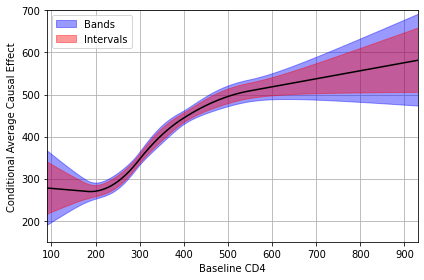

In [17]:
plt.grid(True, zorder=1)
plt.fill_between(xvals, cb[:, 0], cb[:, 1], alpha=0.4, color='blue', zorder=2, label='Bands')
plt.fill_between(xvals, y_hat[:, 2], y_hat[:, 3], alpha=0.4, color='red', zorder=2, label='Intervals')
plt.plot(xvals, y_vals, color='k', zorder=3)
plt.ylim([150, 700])
plt.xlim([90, 930])
plt.xlabel("Baseline CD4")
plt.ylabel("Conditional Average Causal Effect")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Again, we can see the confidence intervals provide much too precise of inference when we are interested in multiple parameters (like a *function*). While confidence bands have not routinely be used, they ought to be and `delicatessen` makes them easy to compute.

**NOTE**: A caveat here is that each case study should be interpreted as if it is independent of the others. If we truly were interested in each of the parameters of each case study and wanted to report them in a single paper, then we should adjust our confidence bands for simultaneous inference on all the parameters described here.

## References

Hammer SM, et al. (1996). "A trial comparing nucleoside monotherapy with combination therapy in HIV-infected adults with CD4 cell counts from 200 to 500 per cubic millimeter". *New England Journal of Medicine*, 335(15), 1081-1090.

Zivich PN, Cole SR, Greifer N, Montoya LM, Kosorok MR, & Edwards JK. (2025). "Confidence Regions for Multiple Outcomes, Effect Modifiers, and Other Multiple Comparisons". *arXiv:2510.07076*